Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px1', 'py1']
O2_orbs =  ['px2', 'py2']
ap_orbs =  []
turn on interactions for symmetries =  ['ALL']
compute A(w) for symmetries =  ['1A1', '1B1', '3B1', '1A2', '3A2', '1E', '3E']
Mc= 16
VS.dim =  267289
No. of states with count_upup, count_updn, count_dnup, count_dndn: 0 134169 133120 0
len(d_list) 25 Nd= 45
E_1S =  12.16
E_1G =  7.76
E_1D =  6.71
E_3P =  7.05
E_3F =  4.8
A= 6.0 ep= 7.0  pds= 1.7320508075688774  pdp= 0.75  pps= 0.9  ppp= 0.2  Upp= 0
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
orbitals in sym  1A1 =  [('dyz', 'dyz'), ('dxz', 'dxz'), ('dxy', 'dxy'), ('d3z2r2', 'd3z2r2'), ('dx2y2', 'dx2y2')]
dd_state_indices 68102 , state: S=  0  Sz=  0 orb=  dx2y2 dx2y2
orbitals in sym  1A2 =  [('dx2y2', 'dxy')]
dd_state_indices 68103 , state: S=  0  Sz=  0 orb=  dxy dx2y2
orbitals in sym  3A2 =  [('dxz', 'dyz'), ('dx2y2',

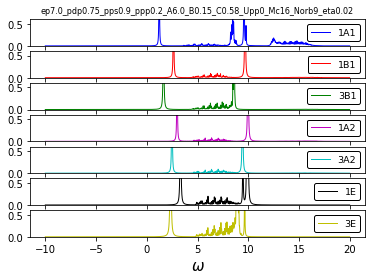

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos
import time
start_time = time.time()

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
                    
Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']
#####################################
def write_Aw(fname,Aw,w_vals):
    f = open('./data_Aw/'+fname,'w',1) 
    f.write('#omega\tspectral weight\n')
    for i in xrange(0,len(w_vals)):
        f.write('{:.6e}\t{:.6e}\n'.format(float(w_vals[i]),Aw[i]))
        
def write_GS(fname,A,ep,tpd,Egs):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_GS/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(A,ep,tpd,Egs))
    
def write_GS2(fname,A,ep,pds,pdp,Egs):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_GS/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(A,ep,pds,pdp,Egs))
    
def write_GS_components(fname,A,ep,tpd,wgt_d8, wgt_d9L, wgt_d10L2):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_GS/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'
            .format(A,ep,tpd, wgt_d8[0],wgt_d8[1],wgt_d8[2],wgt_d8[3],wgt_d8[4],wgt_d8[5],\
             wgt_d9L[0],wgt_d9L[1],wgt_d9L[2],wgt_d9L[3],wgt_d10L2[0]))

def write_GS_components2(fname,A,ep,pds,pdp,wgt_d8, wgt_d9L, wgt_d10L2):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_GS/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'
            .format(A,ep,pds,pdp, wgt_d8[0],wgt_d8[1],wgt_d8[2],wgt_d8[3],wgt_d8[4],wgt_d8[5],\
             wgt_d9L[0],wgt_d9L[1],wgt_d9L[2],wgt_d9L[3],wgt_d10L2[0]))
    
def write_lowpeak(fname,A,ep,tpd,w_peak,weight):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_lowpeak/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(A,ep,tpd,w_peak,weight))
    
def write_lowpeak2(fname,A,ep,pds,pdp,w_peak,weight):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_lowpeak/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(A,ep,pds,pdp,w_peak,weight))
    
def getAw(matrix,index,VS,w_vals):  
    # set up Lanczos solver
    dim  = VS.dim
    scratch = np.empty(dim, dtype = complex)
    Phi0 = np.zeros(dim, dtype = complex)
    Phi0[index] = 1.0
    solver = lanczos.LanczosSolver(maxiter = pam.Lanczos_maxiter, 
                                   precision = 1e-12, 
                                   cond = 'UPTOMAX', 
                                   eps = 1e-8)
    solver.first_pass(x0 = Phi0, scratch = scratch, H = matrix)
    V, D = solver.lanczos_diag_T()

    # D[0,:] is the eigenvector for lowest eigenvalue
    tab = np.abs(D[0,:])**2

    Aw = np.zeros(len(w_vals))
    for n in range(len(V)):
        Aw += tab[n] * eta / M_PI * ( (w_vals - V[n])**2 + eta**2)**(-1)
        
    if pam.if_find_lowpeak==1:
        if pam.peak_mode=='highest_peak':
            w_peak = getAw_peak_highest(Aw, w_vals, D, tab)
        elif pam.peak_mode=='lowest_peak':
            w_peak, weight = getAw_peak_lowest(Aw, w_vals, D, tab)
        elif pam.peak_mode=='lowest_peak_intensity':
            w_peak = getAw_peak_lowest_intensity(Aw, w_vals, D, tab)
    else:
        w_peak = 0; weight = 0
        
    return Aw, w_peak, weight

def getAw_peak_highest(Aw, w_vals, D, tab):  
    '''
    find the position and weight of highest peak of Aw, which might be lowest
    '''    
    w_idx = np.argmax(Aw)
    print 'highest peak index',w_idx
    w_peak = w_vals[w_idx]
    print 'highest peak at w = ', w_peak
    
    '''
    # find the area below the whole peak, namely the peak weight
    # ==========================================================
    # 1. first find the peak's w-range: [w_min, w_max]
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid-1]>Aw[wid]:
            break
        wid -= 1
    w_min = wid
    
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid+1]>Aw[wid]:
            break
        wid += 1
    w_max = wid
    
    print 'highest peak w-range = [', w_vals[w_min], w_vals[w_max], ']'
    
    # 2. Simpson's rule
    weight = integrate.simps(Aw[w_min:w_max], w_vals[w_min:w_max])
    print 'highest peak, weight = ', w_peak, '  ', weight

    # find the eigenvalue D[n] nearest to w_peak so that its index n
    # leads to weight = tab[n]; Note that this weight is actually for 
    # the single peak instead of the area below the whole peak
    tmp = []
    for n in range(len(D)):
        tmp.append(abs(D[n]-w_peak))
        
    idx = tmp.index(min(tmp))
    weight = tab[idx]
    assert(weight>=0.0 and weight<=1.0)
    '''
    return w_peak #, weight

def getAw_peak_lowest(Aw, w_vals, D, tab):  
    '''
    find the position and weight of lowest peak of Aw, which might be highest
    '''    
    w_idx = 0
    # go through the regime with Aw=0 (numerically ~1.e-6)
    while Aw[w_idx]<1.e-3:
        w_idx += 1
    print 'Aw < 1.e-3 until ', w_vals[w_idx]

    # go up until the peak:
    while Aw[w_idx+1]>Aw[w_idx]:
        w_idx += 1
    w_peak = w_vals[w_idx]
    print 'lowest peak at w = ', w_peak
    

    # find the area below the whole peak, namely the peak weight
    # ==========================================================
    # 1. first find the peak's w-range: [w_min, w_max]
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid-1]>Aw[wid]:
            break
        wid -= 1
    w_min = wid
    
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid+1]>Aw[wid]:
            break
        wid += 1
    w_max = wid
    
    print 'lowest peak w-range = [', w_vals[w_min], w_vals[w_max], ']'
    
    # 2. Simpson's rule
    weight = integrate.simps(Aw[w_min:w_max], w_vals[w_min:w_max])
    print 'lowest peak, weight = ', w_peak, '  ', weight

    return w_peak , weight

def getAw_peak_lowest_intensity(Aw, w_vals, D, tab):  
    w_idx = 0
    # go through the regime with Aw=0 (numerically ~1.e-6)
    while Aw[w_idx]<1.e-3:
        w_idx += 1
    print 'Aw < 1.e-3 until ', w_vals[w_idx]

    # go up until the peak:
    while Aw[w_idx+1]>Aw[w_idx]:
        w_idx += 1
    print 'lowest peak intensity = ', Aw[w_idx]
    
    return Aw[w_idx] 

def get_ground_state(matrix,S_val,Sz_val, AorB_sym):  
    '''
    Obtain the ground state info, namely the lowest peak in Aw_dd's component
    in particular how much weight of various d8 channels: a1^2, b1^2, b2^2, e^2
    '''        
    print 'start getting ground state'
    # in case eigsh does not work but matrix is actually small, e.g. Mc=1 (CuO4)
    #M_dense = matrix.todense()
    #print 'H='
    #print M_dense
    #vals, vecs = np.linalg.eigh(M_dense)
    #Neval = M_dense.shape[0]
    #print Neval
    
    # in case eigsh works:
    Neval = pam.Neval
    vals, vecs = sps.linalg.eigsh(matrix, k=Neval, which='SA')
    vals.sort()
    print 'lowest eigenvalue of H = '
    print vals
    
    # get state components in GS and another 9 higher states; note that indices is a tuple
    for k in xrange(0,1):
        #if vals[k]<pam.w_start or vals[k]>pam.w_stop:
        #if vals[k]<11.5 or vals[k]>14.5:
        #if k<Neval:
        #    continue
            
        print 'eigenvalue = ', vals[k]
        indices = np.nonzero(abs(vecs[:,k])>0.05)
        wgt_d8 = zeros(6)
        wgt_d9L = zeros(4)
        wgt_d10L2 = zeros(1)

        print "Compute the weights in GS (lowest Aw peak)"
        #for i in indices[0]:
        for i in range(0,len(vecs[:,k])):
            # state is original state but its orbital info remains after basis change
            state = VS.get_state(VS.lookup_tbl[i])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            x1, y1, z1 = state['hole1_coord']
            x2, y2, z2 = state['hole2_coord']

            # also obtain the total S and Sz of the state
            S12  = S_val[i]
            Sz12 = Sz_val[i]

            o12 = sorted([o1,o2])
            o12 = tuple(o12)
            
            #if abs(x1)>1. or abs(y1)>1. or abs(x2)>1. or abs(y2)>1.:
            #    continue
            if i in indices[0]:
                print 'state ', o12[0],x1,y1,z1,o12[1],x2,y2,z2, 'S=',S12,'Sz=',Sz12, \
                      ", weight = ", abs(vecs[i,k])**2
                
            # record the weights of 1A1 and 3B1 states a1a1, b1b1, ..., a1b1 in G.S.
            if o12[0]==o12[1]=='d3z2r2':
                wgt_d8[0] += abs(vecs[i,k])**2
            if o12==('dx2y2','dx2y2'):
                wgt_d8[1] += abs(vecs[i,k])**2
            if o12[0]==o12[1]=='dxy':
                wgt_d8[2] += abs(vecs[i,k])**2
            if AorB_sym[i]==1:
                wgt_d8[3] += abs(vecs[i,k])**2
            if o12[0]=='d3z2r2' and o12[1]=='dx2y2':
                wgt_d8[4] += abs(vecs[i,k])**2
            if o12[0]=='d3z2r2' and o12[1]=='dxy':
                wgt_d8[5] += abs(vecs[i,k])**2

            if o12[0]=='d3z2r2' and o12[1] in pam.O_orbs:
                wgt_d9L[0] += abs(vecs[i,k])**2
            if o12[0]=='dx2y2'  and o12[1] in pam.O_orbs:
                wgt_d9L[1] += abs(vecs[i,k])**2
            if o12[0]=='dxy'    and o12[1] in pam.O_orbs:
                wgt_d9L[2] += abs(vecs[i,k])**2
            if (o12[0]=='dxz' or o12[0]=='dyz') and o12[1] in pam.O_orbs:
                wgt_d9L[3] += abs(vecs[i,k])**2

            if o12[0] in pam.O_orbs and o12[1] in pam.O_orbs:
                wgt_d10L2[0] += abs(vecs[i,k])**2

    return vals, vecs, wgt_d8, wgt_d9L, wgt_d10L2

def plot_atomic_multiplet_peaks(data_for_maxval):
    maxval = max(data_for_maxval)
    yy = [0,maxval]
    xx = [pam.E_1S,pam.E_1S]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
    xx = [pam.E_1G,pam.E_1G]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
    xx = [pam.E_1D,pam.E_1D]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
    xx = [pam.E_3P,pam.E_3P]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
    xx = [pam.E_3F,pam.E_3F]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
            
def compute_Aw_others(H,A,ep,tpd,pds,pdp,w_vals, pam_flag,ham_func,S_val,Sz_val,AorB_sym,fig_name,flowpeak,fname):
    if pam_flag == 1:
        print 'compute ', fig_name
        state_indices = ham_func(VS, S_val, Sz_val, AorB_sym)
        print state_indices

        print "===================================="
        clf()
        Nstate = len(state_indices)
        for j in range(0,Nstate):
            index = state_indices[j]
            print index
            Aw, w_peak = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=o1+','+o2+',S='+str(S_val[index]))

            # write lowest peak data into file
            if pam.if_find_lowpeak==1 and pam.if_write_lowpeak_ep_tpd==1:
                if Norb==3 or Norb==7:
                    write_lowpeak(fig_name+flowpeak+'.txt',A,ep,tpd,w_peak)
                elif Norb==9 or Norb==10 or Norb==11:
                    write_lowpeak2(fig_name+flowpeak+'.txt',A,ep,pds,pdp,w_peak)

            # write data into file for reusage
            if pam.if_write_Aw==1:
                write_Aw(fig_name+fname+'.txt', Aw, w_vals)
                
            maxval = max(Aw)
            #xlim([-5,20])
            #xlim([0,15])
            ylim([0,maxval])
            #ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig(fig_name+fname+".pdf")

def checkU_unitary(U,U_d):
    UdU = U_d.dot(U)
    sh = UdU.shape
    print sh
    bb = sps.identity(sh[0], format='coo')
    tmp = UdU-bb
    print 'U_d.dot(U)-I = '
    for ii in range(0,sh[0]):
        for jj in range(0,sh[1]):
            if tmp[ii,jj]>1.e-10:
                print tmp[ii,jj]
                
def compute_Aw_main(A,ep,tpd,tpp,pds,pdp,pps,ppp,Upp,d_double,p_double,U, S_val, Sz_val, AorB_sym): 
    if Norb==3:
        Udd = A+4*B+3*C
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
                    '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)
        flowpeak = 'Norb'+str(Norb)+'_tpp'+str(tpp)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_eta'+str(eta)
    elif Norb==7:
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
                  +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                  +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)
        flowpeak = 'Norb'+str(Norb)+'_tpp'+str(tpp)+'_B'+str(B)+'_C'+str(C)+'_Upp'+str(Upp)+ \
                   '_Mc'+str(Mc)+'_eta'+str(eta)
    elif Norb==9 or Norb==10 or Norb==11:
        fname = 'ep'+str(ep)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
                  +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                  +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)
        flowpeak = 'Norb'+str(Norb)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_B'+str(B)+'_C'+str(C)+ \
                 '_Upp'+str(Upp)+'_Mc'+str(Mc)+'_eta'+str(eta)
                
    # set parameter dependent w_vals interval
    # at tpd=0, d9L minimum is at ep-4.*tpp while d10L2 continuum minimum is at 2.*ep-8.*tpp
    # when ep>4*tpp, d9L is lower
    if Norb==3 or Norb==7:
        if ep>4.*tpp:
            val = ep-4.*tpp
        else:
            val = 2.*ep-8.*tpp
    elif Norb==9 or Norb==10 or Norb==11:
        if ep>2.*(pps+ppp):
            val = ep-2.*(pps+ppp)
        else:
            val = 2.*ep-4.*(pps+ppp)
            
    w_start = val-5.5
    w_stop = val+8.5
    #w_vals = np.arange(w_start,w_stop,eta)
    w_vals = np.arange(-10.0, 20.0, eta/5.)
    w_vals = np.arange(-10.0, 20.0, 0.005)

    # set up H0
    if Norb==3 or Norb==7:
        tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac, tpp_nn_hop_fac, apz2p_hop_dir, if_apz2p_hop, apz2p_hop_fac \
                                   = ham.set_tpd_tpp(Norb,tpd,tpp,0,0,0,0)
    elif Norb==9 or Norb==10 or Norb==11:
        tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac, tpp_nn_hop_fac, apz2p_hop_dir, if_apz2p_hop, apz2p_hop_fac \
                                   = ham.set_tpd_tpp(Norb,0,0,pds,pdp,pps,ppp)
    T_pd  = ham.create_tpd_nn_matrix(VS,tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac)
    T_pp  = ham.create_tpp_nn_matrix(VS,tpp_nn_hop_fac)  
    Esite = ham.create_edep_diag_matrix(VS,ep)
    if Norb==10:
        T_apz  = ham.create_apz2p_nn_matrix(VS, apz2p_hop_dir, if_apz2p_hop, apz2p_hop_fac)
        H0 = T_pd + T_pp + T_apz + Esite
    else:
        H0 = T_pd + T_pp + Esite
    
    # check_hermitian for H0
    #H0_max = H0.todense()
    #if ham.check_hermitian(H0_max):
    #    print 'hermitian'

    H0_new = U_d.dot(H0.dot(U))
            
    # for multi d-orbital cases, compute A(w) for each symmetry channel
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))
    
    clf()
    #======================= start opt for Norb =====================================
    if Norb==3:
        Hint, dd_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double,Udd,Upp)
        H = H0_new + Hint
        H.tocsr()
        
        if pam.if_get_ground_state==1:
            vals, vecs, _,_,_ = get_ground_state(H, S_val, Sz_val, AorB_sym)
            write_GS('Egs_'+flowpeak+'.txt',A,ep,tpd,vals[0])
            
        # For debug: check if H is hermitian: only practical for small Mc, namely small matrix
        #out_mat = H.todense()
        #assert(ham.check_hermitian(out_mat)==True)
        
        Nstate = len(dd_state_indices)
        for j in range(0,Nstate):
            index = dd_state_indices[j]
            Aw, w_peak, weight = getAw(H,index,VS,w_vals)   
            
            # write lowest peak data into file
            if pam.if_find_lowpeak==1 and pam.if_write_lowpeak_ep_tpd==1:
                write_lowpeak(flowpeak+'.txt',A,ep,tpd,w_peak,weight)
                
            # write Aw data into file for reusage
            if pam.if_write_Aw==1:
                write_Aw(fname+'.txt',Aw,w_vals)
            
            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            #ylim([0,maxval])
            #ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        if pam.if_savefig_Aw==1:
            savefig("Aw_dd_"+fname+".pdf")

        # plot Matlab data for comparison
        #a = np.loadtxt('../data/dataMatlab.txt',skiprows=1)
        #la = len(a)
        #print la
        #plt.plot(a[0:la/3-1,0], a[0:la/3-1,1], '--c', linewidth=1, label='dd, Matlab')
        #plt.plot(a[la/3:2*la/3-1,0], a[la/3:2*la/3-1,1], '--m', linewidth=1, label='dp, Matlab')
        #plt.plot(a[2*la/3:la-1,0], a[2*la/3:la-1,1], '--k', linewidth=1, label='pp, Matlab')

        #########################################################################
        # compute G_pp and plot
        compute_Aw_others(H, A,ep,tpd, 0,0,w_vals, pam.if_compute_Aw_pp, ham.get_pp_state_indices, \
                          S_val, Sz_val, AorB_sym, "Aw_pp_", flowpeak, fname)

        # compute G_Cu_O_dx2y2 and plot
        compute_Aw_others(H, A,ep,tpd, 0,0,w_vals, pam.if_compute_Aw_Cu_dx2y2_O, ham.get_Cu_dx2y2_O_indices, \
                          S_val, Sz_val, AorB_sym, "Aw_Cu_dx2y2_O_", flowpeak, fname)
        
    elif Norb==7 or Norb==9 or Norb==10 or Norb==11:
        if pam.interaction_sym==['ALL']:
            Hint, dd_state_indices = ham.create_interaction_matrix_ALL_syms(VS,d_double,p_double, \
                                                                    S_val, Sz_val,AorB_sym,A,Upp)
            H = H0_new + Hint  
            H.tocsr()
            
            # compute GS only for turning on full interactions
            if pam.if_get_ground_state==1:
                vals, vecs, wgt_d8, wgt_d9L, wgt_d10L2 = get_ground_state(H, S_val, Sz_val, AorB_sym)
                if Norb==7:
                    write_GS('Egs_'+flowpeak+'.txt',A,ep,tpd,vals[0])
                    write_GS_components('GS_weights_'+flowpeak+'.txt',A,ep,tpd,wgt_d8, wgt_d9L, wgt_d10L2)
                elif Norb==9 or Norb==10 or Norb==11:
                    write_GS2('Egs_'+flowpeak+'.txt',A,ep,pds,pdp,vals[0])
                    write_GS_components2('GS_weights_'+flowpeak+'.txt',A,ep,pds,pdp,wgt_d8, wgt_d9L, wgt_d10L2)
            
        symmetries = pam.symmetries    
        Nsym = len(symmetries)
        for i in range(0,Nsym):
            sym = symmetries[i]
            print "===================================="
            print "start computing A_dd(w) for sym", sym
            
            # if not 'ALL', then turn on interaction for each symmetry one by one
            if pam.interaction_sym!=['ALL']:
                Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double, \
                                                                   S_val, Sz_val, AorB_sym, A, Upp)
                H = H0_new + Hint  
                H.tocsr()
            else:
                _, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double, \
                                                                   S_val, Sz_val, AorB_sym, A, Upp)
                
            #dd_states, d8_states, coef_frac_parentage = ham.get_Aw_state(sym)
            
            # compute G_dd(sym)
            #Aw_dGS = np.zeros(len(w_vals))
            # G.S. weight 
            #wgh_d = 0.57396723003
            #wgh_p = 0.2130163839
            
            Aw_dd = np.zeros(len(w_vals))
            for index in dd_state_indices:      
                Aw, w_peak, weight = getAw(H,index,VS,w_vals)
                Aw_dd += Aw  #*coef_frac_parentage[spinorb]
                #Aw_dGS += wgh_d*Aw
                
                # write lowest peak data into file
                if pam.if_find_lowpeak==1 and pam.if_write_lowpeak_ep_tpd==1:
                    if Norb==7:
                        write_lowpeak(flowpeak+'_'+sym+'.txt',A,ep,tpd,w_peak, weight)
                    elif Norb==9:
                        write_lowpeak2(flowpeak+'_'+sym+'.txt',A,ep,pds,pdp,w_peak, weight)
                          
            # write data into file for reusage
            if pam.if_write_Aw==1:
                write_Aw(fname+'_'+sym+'.txt', Aw_dd, vals[0]-w_vals)
                
            # accumulate Aw for each sym into total Aw_dd
            Aw_dd_total += Aw_dd
            
            subplot(Nsym,1,i+1)
            plt.plot(w_vals, Aw_dd, Ms[i], linewidth=1, label=sym)
            #plt.plot(w_vals, Aw_dGS, Ms[i], linewidth=1, label=sym)
            
            # plot atomic multiplet peaks
            #plot_atomic_multiplet_peaks(Aw_dd)
                
            if i==0:
                title(fname, fontsize=8)
            if i==Nsym-1:
                xlabel('$\omega$',fontsize=15)
                
            maxval = max(Aw_dd)
            #xlim([-5,20])
            ylim([0,maxval])
            ylim([0,0.6])
            #ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
            #yticks(fontsize=12) 
            
        if Nsym>0 and pam.if_savefig_Aw==1:    
            savefig("Aw_dd_"+fname+"_sym.pdf")
            
        #########################################################################
        if Norb==7:
            # compute G_pp and plot
            compute_Aw_others(H, A,ep,tpd,0,0,w_vals, pam.if_compute_Aw_pp, ham.get_pp_state_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_pp_", flowpeak, fname)

            # compute G_dp and plot
            compute_Aw_others(H, A,ep,tpd,0,0,w_vals, pam.if_compute_Aw_dp, ham.get_dp_state_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_dp_", flowpeak, fname)

            # compute G_Cu_O_dx2y2 and plot
            compute_Aw_others(H, A,ep,tpd,0,0,w_vals, pam.if_compute_Aw_Cu_dx2y2_O, ham.get_Cu_dx2y2_O_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_Cu_dx2y2_O_", flowpeak, fname)
        elif Norb==9 or Norb==10 or Norb==11:
            # compute G_pp and plot
            compute_Aw_others(H, A,ep,0, pds,pdp, w_vals, pam.if_compute_Aw_pp, ham.get_pp_state_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_pp_", flowpeak, fname)

            # compute G_dp and plot
            compute_Aw_others(H, A,ep,0, pds,pdp, w_vals, pam.if_compute_Aw_dp, ham.get_dp_state_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_dp_", flowpeak, fname)

            # compute G_Cu_O_dx2y2 and plot
            compute_Aw_others(H, A,ep,0, pds,pdp, w_vals, pam.if_compute_Aw_Cu_dx2y2_O, ham.get_Cu_dx2y2_O_indices, \
                              S_val, Sz_val, AorB_sym, "Aw_Cu_dx2y2_O_", flowpeak, fname)
        ############################################################
        # plot total Gdd
        if pam.if_compute_Aw_dd_total == 1:
            clf()
            plt.plot(w_vals, Aw_dd_total,'-b', linewidth=1)
            title(fname, fontsize=8)
            maxval = max(Aw_dd_total)
            xlim([-5,0])
            ylim([0,maxval])
            xlabel('$\omega$',fontsize=17)
            ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')

            # plot atomic multiplet peaks
            plot_atomic_multiplet_peaks(Aw_dd_total)

            savefig("Aw_dd_"+fname+"_total.pdf")

def get_atomic_d8_energy(A,B,C):
    E_1S = A+14*B+7*C
    E_1G = A+4*B+2*C
    E_1D = A-3*B+2*C
    E_3P = A+7*B
    E_3F = A-8*B
    print "E_1S = ", E_1S      
    print "E_1G = ", E_1G     
    print "E_1D = ", E_1D 
    print "E_3P = ", E_3P
    print "E_3F = ", E_3F
    
##########################################################################
if __name__ == '__main__': 
    As = pam.As
    B  = pam.B
    C  = pam.C
    
    # set up VS
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    
    d_double, p_double = ham.get_double_occu_list(VS)
    
    # change the basis for d_double states to be singlet/triplet
    if pam.basis_change_type=='all_states':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix(VS,d_double)
        if pam.if_print_VS_after_basis_change==1:
            basis.print_VS_after_basis_change(VS,S_val,Sz_val)
    elif pam.basis_change_type=='d_double':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix_d_double(VS,d_double)

    U_d = (U.conjugate()).transpose()
    # check if U if unitary
    #checkU_unitary(U,U_d)
    
    if Norb==3:
        for ep in pam.eps:
            for tpd in pam.tpds:
                for tpp in pam.tpps:
                    for Upp in pam.Upps:
                        for A in As:
                            Udd = A+4*B+3*C
                            print '==================================================='
                            print 'A=',A, 'Udd=',Udd, 'ep=', ep, ' tpd=',tpd,' tpp=',tpp,' Upp=',Upp 
                            compute_Aw_main(A,ep,tpd,tpp,0,0,0,0,Upp,d_double,p_double,U, S_val, Sz_val, AorB_sym)
    elif Norb==7:
        for tpd in pam.tpds:
            for ep in pam.eps:               
                for A in pam.As:
                    get_atomic_d8_energy(A,B,C)
                    for tpp in pam.tpps:
                        for Upp in pam.Upps:
                            print '==================================================='
                            print 'A=',A, 'ep=', ep, ' tpd=',tpd,' tpp=',tpp,' Upp=',Upp 
                            compute_Aw_main(A,ep,tpd,tpp,0,0,0,0,Upp,d_double,p_double,U, S_val, Sz_val, AorB_sym)
    elif Norb==9 or Norb==10 or Norb==11:
        pps = pam.pps
        ppp = pam.ppp
        for ii in range(0,len(pam.pdps)):
            pds = pam.pdss[ii]
            pdp = pam.pdps[ii]
            for ep in pam.eps:
                for A in pam.As:
                    get_atomic_d8_energy(A,B,C)
                    for Upp in pam.Upps:
                        print '==================================================='
                        print 'A=',A, 'ep=',ep,' pds=',pds,' pdp=',pdp,' pps=',pps,' ppp=',ppp,' Upp=',Upp 
                        compute_Aw_main(A,ep,0,0,pds,pdp,pps,ppp,Upp,d_double,p_double,U, S_val, Sz_val, AorB_sym)                 
    print("--- %s seconds ---" % (time.time() - start_time))